In [1]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy,error_rate

#### Class for reading the data directly into fast.ai, created by 
https://www.kaggle.com/c/digit-recognizer/discussion/80243#latest-525194

In [2]:
class CustomImageItemList(ImageList):
    def open(self, fn):
        img = fn.reshape(28,28)
        img = np.stack((img,)*3, axis=-1) # convert to 3 channels
        return Image(pil2tensor(img, dtype=np.float32))

    @classmethod
    def from_csv_custom(cls, path:PathOrStr, csv_name:str, imgIdx:int=1, header:str='infer', **kwargs)->'ItemList':
        df = pd.read_csv(Path(path)/csv_name, header=header)
        res = super().from_df(df, path=path, cols=0, **kwargs)
        # convert pixels to an ndarray
        res.items = df.iloc[:,imgIdx:].apply(lambda x: x.values / 255.0, axis=1).values
        return res

In [3]:
path = '../input'

In [4]:
test = CustomImageItemList.from_csv_custom(path=path, csv_name='test.csv', imgIdx=0)
data = (CustomImageItemList.from_csv_custom(path=path, csv_name='train.csv')
                           .split_by_rand_pct(.2)
                           .label_from_df(cols='label')
                           .add_test(test, label=0)
                           .databunch(bs=64, num_workers=0)
                           .normalize(imagenet_stats))

In [5]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate,model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:05<00:00, 18180020.97it/s]


In [6]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.654402,0.503916,0.160476,00:35
1,0.287693,0.207291,0.063452,00:32
2,0.191032,0.136768,0.042143,00:32
3,0.133883,0.119462,0.038214,00:33


In [7]:
learn.save("model_1", return_path=True)

PosixPath('/tmp/model/model_1.pth')

In [8]:
learn.unfreeze()

In [9]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.057809,0.033722,0.009167,00:41


In [10]:
learn.load('model_1')

Learner(data=ImageDataBunch;

Train: LabelList (33600 items)
x: CustomImageItemList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
1,0,1,4,0
Path: ../input;

Valid: LabelList (8400 items)
x: CustomImageItemList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,5,1,1,0
Path: ../input;

Test: LabelList (28000 items)
x: CustomImageItemList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
0,0,0,0,0
Path: ../input, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


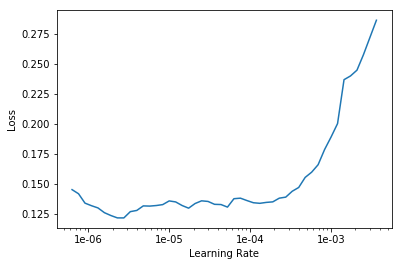

In [12]:
learn.recorder.plot()

In [13]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.120754,0.099041,0.030952,00:41
1,0.093536,0.068756,0.020952,00:41
2,0.064406,0.052099,0.015357,00:41
3,0.046136,0.046709,0.014881,00:41
4,0.027924,0.038626,0.011310,00:41
5,0.017897,0.037010,0.009286,00:42
6,0.013022,0.035250,0.008929,00:41
7,0.004012,0.032794,0.008452,00:41
8,0.002810,0.032353,0.008571,00:41


In [14]:
# get the predictions
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
# output to a file
submission_df = pd.DataFrame({'ImageId': list(range(1,len(labels)+1)), 'Label': labels})
submission_df.to_csv(f'submission.csv', index=False)